## Exploring network connectivity and centrality

In [ ]:
%matplotlib notebook
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import brian2
import matplotlib
import matplotlib.pyplot as plt
import glob
import re
import io
import os
import sys 
import scipy.sparse.linalg
from statistics import mean
from itertools import count
import seaborn as sns

<AxesSubplot:>

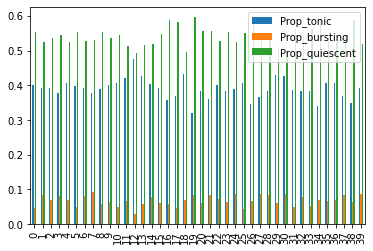

In [11]:
df = pd.read_csv('damgo_ramp.csv')
df = df.drop(columns=['Unnamed: 0'])
# T_count = 0
# B_count = 0
# Q_count = 0
T_props = []
B_props = []
Q_props = []
for seed in range(1,41):
    G = nx.read_gpickle(f'networkx_objects/seed{seed}graph.pkl')
    T_count = 0
    B_count = 0
    Q_count = 0
    for i in range(len(G.nodes)):
        if G.nodes[i]['spike_type'] == 'tonic':
            T_count += 1
        elif G.nodes[i]['spike_type'] == 'quiescent':
            Q_count += 1
        else:
            B_count += 1
    T_props.append(T_count / 300)
    B_props.append(B_count / 300)
    Q_props.append(Q_count / 300)

d = {'Prop_tonic': T_props, 'Prop_bursting': B_props, 'Prop_quiescent': Q_props}

In [16]:
print(avg_T_prop)
print(avg_B_prop)
print(avg_Q_prop)

0.39075

In [1]:
avg_B_prop

NameError: name 'avg_B_prop' is not defined

In [13]:
G.nodes[3]['spike_type']

'quiescent'

### Algebraic connectivity of the networks

In [2]:
df = pd.read_csv('damgo_ramp.csv')
df = df.drop(columns=['Unnamed: 0'])
sub_G_fiedler_eigs = []
for seed in range(1,41):
    G = nx.read_gpickle(f'networkx_objects/seed{seed}graph.pkl')
    # add weights (max synaptic strength)
#     for u, v, attr in G.edges(data=True):
#         if u >= 60:
#             G[u][v]['weight'] = 3.5
#         elif u < 60:
#             G[u][v]['weight'] = -3.5
            
    # create subgraph based on neuron type
    nodes = (
        node
        for node, data
        in G.nodes(data=True)
        if data.get('neuron_type') == 'oprm1' or data.get('neuron_type') == 'exc'
    )
    sub_G = G.subgraph(nodes)

    # compute eigenvalues of Laplacian of G
    L=np.array(nx.directed_laplacian_matrix(sub_G))
    eigs = np.linalg.eigvalsh(L)
    print(f'Seed {seed} excitatory connectivity = {eigs[1]}')
    sub_G_fiedler_eigs.append(eigs[1])


AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

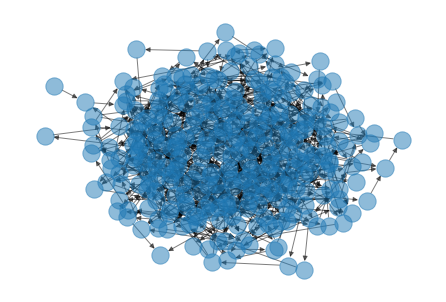

In [15]:
%matplotlib inline
nx.draw(G,alpha=0.5,pos=nx.kamada_kawai_layout(G))

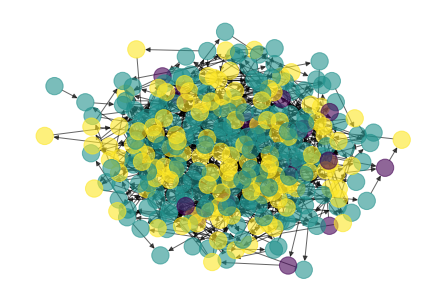

In [34]:
# get unique groups
%matplotlib inline
groups = set(nx.get_node_attributes(G,'spike_type').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['spike_type']] for n in nodes]
nx.draw(G,alpha=0.6,pos=nx.kamada_kawai_layout(G), node_color = colors)
plt.savefig('network.png',dpi=300)

In [6]:
df = pd.read_csv('damgo_ramp.csv')
df = df.drop(columns=['Unnamed: 0'])
G_fiedler_eigs = []
for seed in range(1,41):
    G = nx.read_gpickle(f'networkx_objects/seed{seed}graph.pkl')
    # compute eigenvalues of Laplacian of G
    L=np.array(nx.directed_laplacian_matrix(G))
    eigs = np.linalg.eigvalsh(L)
    print(f'Seed {seed} overall connectivity = {eigs[1]}')
    G_fiedler_eigs.append(eigs[1])

Seed 1 overall connectivity = 0.2408016877782778
Seed 2 overall connectivity = 0.1985169863950478
Seed 3 overall connectivity = 0.20368317469581115
Seed 4 overall connectivity = 0.23602252475022606
Seed 5 overall connectivity = 0.23669849335475557
Seed 6 overall connectivity = 0.21894919134073731
Seed 7 overall connectivity = 0.1786717906716963
Seed 8 overall connectivity = 0.2681603433326408
Seed 9 overall connectivity = 0.04491546892443166
Seed 10 overall connectivity = 0.05014357797094299
Seed 11 overall connectivity = 0.23209988360586936
Seed 12 overall connectivity = 0.04768617003806663
Seed 13 overall connectivity = 0.23214648157917464
Seed 14 overall connectivity = 0.21642418628813287
Seed 15 overall connectivity = 0.2339694891356104
Seed 16 overall connectivity = 0.20355430144860562
Seed 17 overall connectivity = 0.17392054057504053
Seed 18 overall connectivity = 0.24220404677015933
Seed 19 overall connectivity = 0.2255249547981717
Seed 20 overall connectivity = 0.2089485089537

In [ ]:
dra

<IPython.core.display.Javascript object>


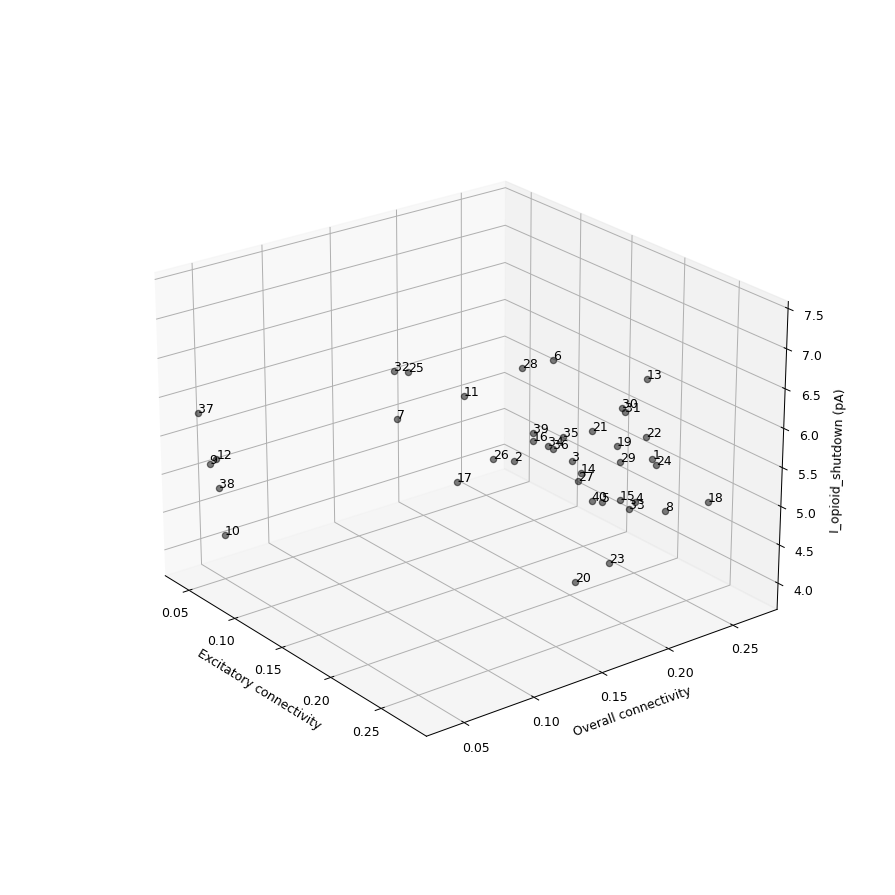

Text(0.5, 0, 'I_opioid_shutdown (pA)')

In [7]:
%matplotlib notebook
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection = '3d')
ax.plot(sub_G_fiedler_eigs, G_fiedler_eigs, df['I_opioid_shutdown'], '.', color = 'k', alpha = 0.5, markersize = 10)

for i in range(len(sub_G_fiedler_eigs)):
    ax.text(sub_G_fiedler_eigs[i], G_fiedler_eigs[i], df['I_opioid_shutdown'][i], df['run_seed'][i])

ax.set_xlabel('Excitatory connectivity')
ax.set_ylabel('Overall connectivity')
ax.set_zlabel('I_opioid_shutdown (pA)')

### Group centrality of excitatory population

In [ ]:
plt.figure(figsize=(8,8))
for seed in range(1,41):
    G = nx.read_gpickle(f'networkx_objects/seed{seed}graph.pkl')
    nodes = {
        node
        for node, data
        in G.nodes(data=True)
        if data.get('neuron_type') == 'oprm1' or data.get('neuron_type') == 'exc'
    }
    sub_G = G.subgraph(nodes)
    cent = nx.group_betweenness_centrality(sub_G, nodes)
    #print(cent)
    plt.plot(cent, df['LD50'][seed-1],'.',color='b')
    plt.text(cent, df['LD50'][seed-1], df['run_seed'][seed-1])

plt.xlabel('Group betweenness centrality of oprm1 neurons')
plt.ylabel('LD50 (pA)')
#sorted(cent.items(), key = lambda x:x[1], reverse = True)

In [86]:
sub_G.nodes

NodeView((60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179))

### Eigenvector centrality of individual neurons

In [8]:
plt.figure(figsize=(8,8))
for seed in range(1,41):
    G = nx.read_gpickle(f'graph_data/seed{seed}graph.pkl')
    
    nodes = (
        node
        for node, data
        in G.nodes(data=True)
        if data.get('neuron_type') == 'oprm1' or data.get('neuron_type') == 'exc'
    )
    
    sub_G = G.subgraph(nodes)
    cent = nx.eigenvector_centrality(sub_G)
    ranking = sorted(cent.items(), key = lambda x:x[1], reverse = True)[0:12]
    
    plt.plot(mean(dict(ranking).values()), df['I_opioid_shutdown'][seed-1],'.',color='k',alpha=0.5)
    plt.text(mean(dict(ranking).values()), df['I_opioid_shutdown'][seed-1], seed)
    
plt.xlabel('Mean eigenvector centrality of excitatory neurons')
plt.ylabel('Threshold shutdown value (pA)')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Threshold shutdown value (pA)')

In [59]:
G = nx.read_gpickle(f'graph_data/seed25graph.pkl')

nodes = (
    node
    for node, data
    in G.nodes(data=True)
    if data.get('neuron_type') == 'oprm1' or data.get('neuron_type') == 'exc'
)

sub_G = G.subgraph(nodes)
cent = nx.eigenvector_centrality(sub_G)
ranking = sorted(cent.items(), key = lambda x:x[1], reverse = True)[0:12]
ranking

[(118, 0.21778760410227568),
 (256, 0.17219997205717216),
 (247, 0.1703155942852546),
 (63, 0.1609554749524324),
 (83, 0.1463745795103703),
 (165, 0.1359098775797858),
 (240, 0.1313802233458236),
 (228, 0.13028756343403214),
 (241, 0.12673998798009903),
 (219, 0.12490555614926781),
 (81, 0.12005851328193112),
 (205, 0.119408541643692)]

In [60]:
for i in range(len(ranking)):
    print(list(G.nodes(data=True))[ranking[i][0]])

(118, {'neuron_type': 'oprm1', 'spike_type': 'burst'})
(256, {'neuron_type': 'exc', 'spike_type': 'quiescent'})
(247, {'neuron_type': 'exc', 'spike_type': 'quiescent'})
(63, {'neuron_type': 'oprm1', 'spike_type': 'tonic'})
(83, {'neuron_type': 'oprm1', 'spike_type': 'quiescent'})
(165, {'neuron_type': 'oprm1', 'spike_type': 'tonic'})
(240, {'neuron_type': 'exc', 'spike_type': 'tonic'})
(228, {'neuron_type': 'exc', 'spike_type': 'tonic'})
(241, {'neuron_type': 'exc', 'spike_type': 'quiescent'})
(219, {'neuron_type': 'exc', 'spike_type': 'quiescent'})
(81, {'neuron_type': 'oprm1', 'spike_type': 'quiescent'})
(205, {'neuron_type': 'exc', 'spike_type': 'tonic'})


### Counts of tonic vs quiescent

In [77]:
t_counts = []
q_counts = []
for seed in range(1,41):
    G = nx.read_gpickle(f'graph_data/seed{seed}graph.pkl')
    t_nodes = (
        node
        for node, data
        in G.nodes(data=True)
        if data.get('spike_type') == 'tonic'
    )
    tonic_G = G.subgraph(t_nodes)
    t_counts.append(len(tonic_G.nodes))

    q_nodes = (
        node
        for node, data
        in G.nodes(data=True)
        if data.get('spike_type') == 'quiescent'
    )
    quiescent_G = G.subgraph(q_nodes)
    q_counts.append(len(quiescent_G.nodes))

<IPython.core.display.Javascript object>


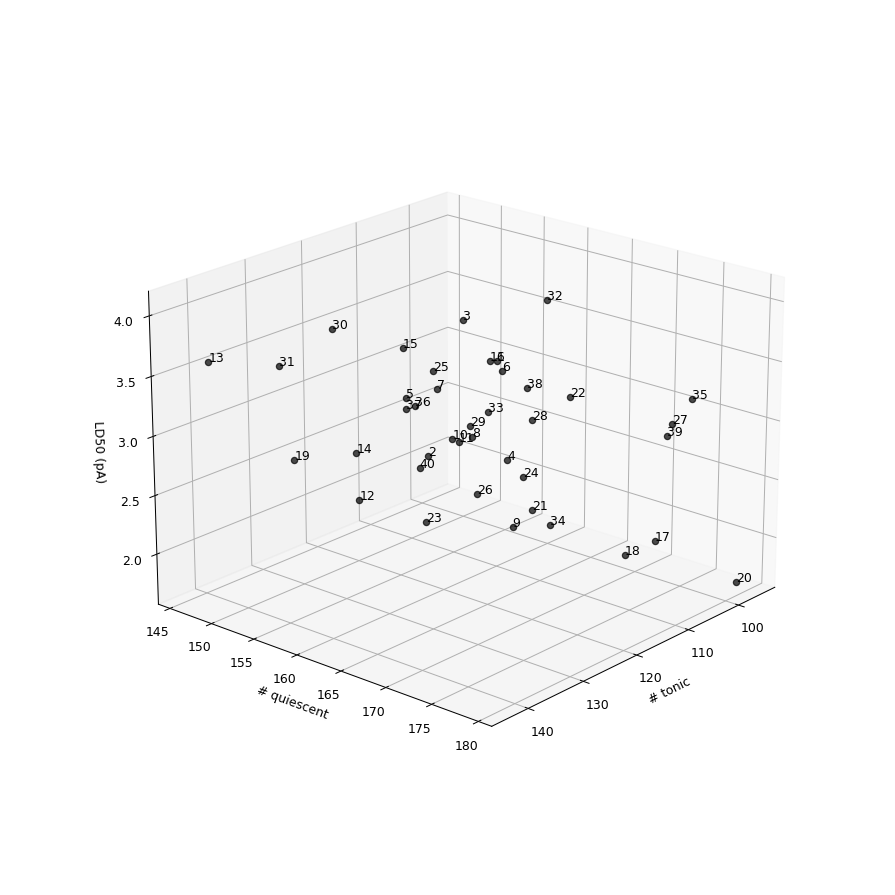

In [78]:
%matplotlib notebook
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection = '3d')
ax.plot(t_counts, q_counts, df['LD50'], '.', color = 'k', alpha = 0.7, markersize = 10)
for i in range(len(t_counts)):
    ax.text(t_counts[i], q_counts[i], df['LD50'][i], df['run_seed'][i])

ax.set_xlabel('# tonic')
ax.set_ylabel('# quiescent')
ax.set_zlabel('LD50 (pA)')

plt.show()

<IPython.core.display.Javascript object>


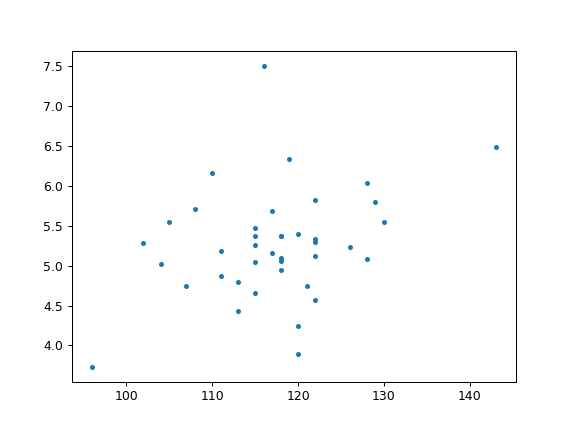

In [48]:
plt.figure()
plt.plot(t_counts, df['I_opioid_shutdown'],'.')